<a href="https://colab.research.google.com/github/SaiSalian07/Thesis/blob/main/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import nltk
import torch
import joblib
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel


nltk.download('stopwords')

# Loading the dataset
df = pd.read_csv('/content/drive/My Drive/Thesis - Phishing Detection/Datasets/phishing_email.csv')

# To display the first few rows of the dataset
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0


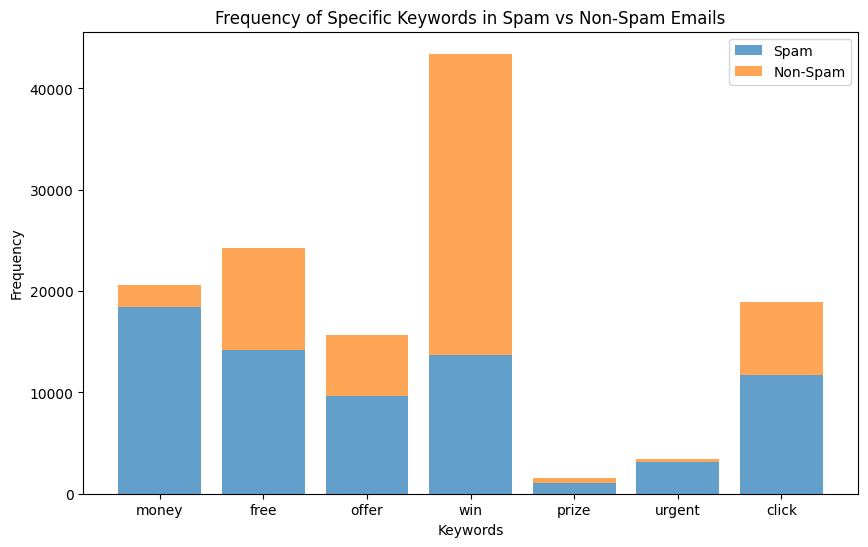

In [ ]:
# @title Frequency of Specific Keywords in Spam vs Non-Spam Emails

import matplotlib.pyplot as plt

keywords = ['money', 'free', 'offer', 'win', 'prize', 'urgent', 'click']

spam_counts = [df[df['label'] == 1]['text_combined'].str.lower().str.count(keyword).sum() for keyword in keywords]
non_spam_counts = [df[df['label'] == 0]['text_combined'].str.lower().str.count(keyword).sum() for keyword in keywords]

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(keywords, spam_counts, label='Spam', alpha=0.7)
plt.bar(keywords, non_spam_counts, bottom=spam_counts, label='Non-Spam', alpha=0.7)

plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Frequency of Specific Keywords in Spam vs Non-Spam Emails')
_ = plt.legend()


In [3]:
import string

def preprocess_text(text_combined):
    stop_words = set(stopwords.words('english'))
    text = text_combined.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['text_combined'] = df['text_combined'].apply(preprocess_text)

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_combined'], df['label'], test_size=0.2, random_state=42)

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Check if GPU is available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

def get_embeddings(texts, tokenizer, model, device, batch_size=32):
    """Function to get DistilBERT embeddings for a list of texts."""
    embeddings = []
    model.eval()

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512).to(device)
            outputs = model(**inputs)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)

    return np.array(embeddings)

# Get embeddings for training and testing sets
X_train_embeddings = get_embeddings(X_train.tolist(), tokenizer, model, device)
X_test_embeddings = get_embeddings(X_test.tolist(), tokenizer, model, device)

X_train_embeddings = X_train_embeddings.reshape(X_train_embeddings.shape[0], -1)
X_test_embeddings = X_test_embeddings.reshape(X_test_embeddings.shape[0], -1)

# Verify shapes
print(f'Training embeddings shape: {X_train_embeddings.shape}')
print(f'Test embeddings shape: {X_test_embeddings.shape}')

tokenizer.save_pretrained('/content/drive/My Drive/Thesis - Phishing Detection/Models/tokenizer')
model.save_pretrained('/content/drive/My Drive/Thesis - Phishing Detection/Models/distilbert_model')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Training embeddings shape: (65988, 768)
Test embeddings shape: (16498, 768)


In [7]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_embeddings, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_embeddings)

print(classification_report(y_test, y_pred))
joblib.dump(clf, '/content/drive/My Drive/Thesis - Phishing Detection/Models/random_forest_model.pkl')

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7935
           1       0.97      0.96      0.97      8563

    accuracy                           0.97     16498
   macro avg       0.97      0.97      0.97     16498
weighted avg       0.97      0.97      0.97     16498



['/content/drive/My Drive/Thesis - Phishing Detection/Models/random_forest_model.pkl']

In [8]:
# Load the saved RandomForest model
clf_loaded = joblib.load('/content/drive/My Drive/Thesis - Phishing Detection/Models/random_forest_model.pkl')

# Load the tokenizer and DistilBERT model
tokenizer_loaded = DistilBertTokenizer.from_pretrained('/content/drive/My Drive/Thesis - Phishing Detection/Models/tokenizer')
model_loaded = DistilBertModel.from_pretrained('/content/drive/My Drive/Thesis - Phishing Detection/Models/distilbert_model')
model_loaded.to(device)

# Get embeddings for the test set using the loaded tokenizer and model
X_test_embeddings_loaded = get_embeddings(X_test.tolist(), tokenizer_loaded, model_loaded, device)
X_test_embeddings_loaded = X_test_embeddings_loaded.reshape(X_test_embeddings_loaded.shape[0], -1)

# Make predictions using the loaded RandomForest model
y_pred_loaded = clf_loaded.predict(X_test_embeddings_loaded)

# Print the classification report
print(classification_report(y_test, y_pred_loaded))


              precision    recall  f1-score   support

           0       0.96      0.97      0.97      7935
           1       0.97      0.96      0.97      8563

    accuracy                           0.97     16498
   macro avg       0.97      0.97      0.97     16498
weighted avg       0.97      0.97      0.97     16498



In [4]:
!git init


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [5]:
!git config --global user.email "x22183761@student.ncirl.ie"
!git config --global user.name "SaiSalian07"




In [6]:
!git push origin main



fatal: not a git repository (or any of the parent directories): .git
